## Hands-on EESREP 2 : Flexible nuclear and CCGT plants supplying a balanced electric grid

This serie of file "Hands-on EESREP" is dedicated to the study of flexibility features in the EESREP simulation model. The primary objective is to incorporate advanced components whose flexibility is in some way restricted by physical phenomena or safety regulations.

The tutorial use_2_three_components_model.ipynb serves as the foundation for this code, which will introduce flexibility restrictions to the nuclear cluster in Hands-on EESREP 2, while the CCGT model will remain optimistic. Hence, the model uses seven main components:

-   load: fatal sink that consumes a predetermined amount of energy ;

-   cluster_Nuke: group of N1 nuclear power plants that produce energy between its minimal and maximal power when turned-on ;
-   cluster_CCGT: group of N2 Combined Cycle Gas Turbine (CCGT) that produce energy between its minimal and maximal power when turned-on ;

-   fuel_Nuke: provides the energy requested by the cluster_Nuke ;
-   fuel_CCGT: provides the energy requested by the cluster_CCGT ;

-   demand-side management: virtual production plant - that provides the system with unsupplied_energy - ensures the equilibrium between energy bid and ask. The energy is charged at a significantly higher rate compared to the rate of physical assets ;
-   spilled_energy: physical consumption plant that will consume energy on demand to ensure an equilibrium between energy bid and ask when flexibility restrictions induce a spread. The charge for consumption is intended to prevent the solver from overproducing.

A "bus" has been added to enable Kirchhoff's junction rule between the inputs and the outputs.

The model's structure can be exemplified as follows:

                                             | -->  load
              fuel_Nuke --> cluster_Nuke --> |
              fuel_CCGT --> cluster_CCGT --> |
                  demand-side management --> |
                                             | --> spilled_energy

### Imports

In [16]:
import math

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from eesrep import Eesrep
from eesrep.components.generic_component import GenericComponent
from eesrep.components.converter import Cluster
from eesrep.components.sink_source import FatalSink, Source, Sink
from eesrep.eesrep_enum import TimeSerieType
from eesrep.solver_interface.generic_interface import GenericInterface

### New components

In [18]:
class FlexiblePP_static(GenericComponent):
    """EESREP flexible power plant static model :
        The output evolution satisfies static constraints set through ramp_up and ramp_down"""

    def __init__(self, 
                    name:str,
                    efficiency:float,
                    p_max:float,
                    p_min_rel:float,
                    duration_on:float,
                    duration_off:float,
                    opex:float,
                    turn_on_price:float,
                    ramp_up:float,
                    ramp_down:float,
                    bool_ramps:float,
                    bool_creditFPPI:float,
                    some_ts:pd.DataFrame = pd.DataFrame()):
        
        self.name = name
        self.efficiency = efficiency
        self.p_max = p_max
        self.p_min_off = 0
        self.p_min_on = p_min_rel * p_max
        self.duration_on = duration_on
        self.duration_off = duration_off
        self.opex = opex
        self.turn_on_price = turn_on_price
        self.ramp_up = ramp_up
        self.ramp_down = ramp_down
        self.bool_ramps = bool_ramps
        self.bool_creditFPPI = bool_creditFPPI

        #   Necessary object, instanciate empty if not used
        self.time_series = {
            # "some_time_serie":{
            #     "type":TimeSerieType.INTENSIVE,
            #     "value":some_ts
            # } 
        }

        self.boolstate = "boolstate"
        self.creditFPPI = "creditFPPI"
        self.electricity = "electricity"
        self.fuel = "fuel"

    def io_from_parameters(self) -> dict:
        """Lists the component Input/Output.
        """
        return {
                    "boolstate":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "creditFPPI":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "electricity":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":True
                                },
                    "fuel":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":False
                                }
                }
    
    def build_model(self,
        component_name:str,
        time_steps:list,
        time_series:pd.DataFrame,
        history:pd.DataFrame,
        model_interface:GenericInterface):
        """Builds the model at the current horizon.

        Parameters
        ----------
        component_name : str
            Component name to index the MILP variables
        time_steps : list
            List of the time steps length 
        time_series : pd.DataFrame
            Dataframe containing the time series values at the current horizon time steps.
        history : pd.DataFrame
            Dataframe with the variables of previous iterations if "continuity" is at true.
        model_interface : GenericInterface
            Solver interface used to provide the variables

        """
        variables = {}

        variables["boolstate"] = model_interface.get_new_discrete_variable_list(component_name+"_boolstate_", len(time_steps), 0, 1)
        variables["creditFPPI"] = model_interface.get_new_continuous_variable_list(component_name+"_creditFPPI_", len(time_steps), 0, 8*24)
        variables["fuel"] = model_interface.get_new_continuous_variable_list(component_name+"_fuel_", len(time_steps), 0, None)
        variables["electricity"] = model_interface.get_new_continuous_variable_list(component_name+"_electricity_", len(time_steps), self.p_min_off, self.p_max)

        ratio_p_min_p_max = [0 for i in range(len(time_steps))]

        for i in range(len(time_steps)):
            # Static constraint of imperfect transformation of inputs into outputs
            model_interface.add_equality(left_term = model_interface.sum_variables([
                                                                variables["electricity"][i],
                                                                -variables["fuel"][i]*self.efficiency
                                                            ]), 
                                         right_term = 0)
            burn_up = i/(len(time_steps)-1)
            if burn_up <= 0.1:
                ratio_p_min_p_max[i] = 1
            elif burn_up <= 0.65:
                ratio_p_min_p_max[i] = 0.2
            elif burn_up <= 0.9:
                ratio_p_min_p_max[i] = 0.2 + (burn_up-0.65) * (0.86-0.2)/(0.9-0.65)
            else:
                ratio_p_min_p_max[i] = 0.86

            # Static constraints of limited output range while running
            model_interface.add_lower_than(left_term = variables["electricity"][i], 
                                           right_term = self.p_max * variables["boolstate"][i])
            model_interface.add_greater_than(left_term = variables["electricity"][i], 
                                             right_term = self.p_min_on * variables["boolstate"][i])
            #model_interface.add_greater_than(left_term = variables["electricity"][i], 
            #                                 right_term = self.p_max * ratio_p_min_p_max[i] * variables["boolstate"][i])


            if self.bool_ramps:
                
                current_step_elec = variables["electricity"][i]

                # Intermediate assignement of the previous step
                if i == 0:
                    # First step of the current horizon : the previous step may not exist and might be fetched in the history
                    if len(history) == 0:
                        # First step of the first horizon : no constraints
                        last_step_elec = 0
                        last_step_boolstate = 0
                    else:
                        # First step of a generic horizon : previous step must be fetched in history
                        last_step_elec = history.loc[len(history)-1,"electricity"]
                        last_step_boolstate = history.loc[len(history)-1,"boolstate"]
                    # end if
                else:
                    # Not the first step of the current horizon : the previous step exists locally
                    last_step_elec = variables["electricity"][i-1]
                    last_step_boolstate = variables["boolstate"][i-1]
                # end if
                
                # Intermediate assignement of the next step
                if i == len(time_steps) - 1:
                    # Last step of the current horizon : the next one does not exist
                    next_step_boolstate = 1
                else:
                    # Not the last step of the current horizon : the next step exists locally
                    next_step_boolstate = variables["boolstate"][i+1]
                # end if

                # Cas premier horizon :
                    # Ramping up : état + élec précédent existe pas au premier pas
                    # Ramping down : besoin élec précédent mais jamais relaxé au dernier pas
                # Cas horizon qcq :
                    # Ramping up : état + élec précédent au premier pas à chercher dans history
                    # Ramping down : besoin élec précédent dans history au premier pas mais jamais relaxé au dernier pas

                # Ramping up constraint, relaxed if boolstate is null at the previous timestep
                model_interface.add_lower_than(left_term = model_interface.sum_variables([
                                                                    current_step_elec,
                                                                    -last_step_elec,
                                                                    -self.p_max * self.ramp_up,
                                                                    -(1 - last_step_boolstate) * 1e9
                                                                ]),
                                            right_term = 0)

                # Ramping down constraint, relaxed if boolstate is null at the next timestep
                model_interface.add_greater_than(left_term = model_interface.sum_variables([
                                                                    current_step_elec,
                                                                    -last_step_elec,
                                                                    self.p_max * self.ramp_down,
                                                                    -1e9 * (1-next_step_boolstate)
                                                                ]),
                                            right_term = 0)
            # end if self.bool_ramps
                
            if self.bool_creditFPPI:

                current_step_creditFPPI = variables["creditFPPI"][i]
                current_step_boolstate = variables["boolstate"][i]
                debit_prop = 1
                debit_horaire = 1 - debit_prop

                if i==0:
                    if len(history)==0:
                        # Initialize the FPPI Credit at the first step of the first horizon
                        last_step_creditFPPI = 8*24
                    else:
                        # Fetch the FPPI Credit at the last step of the previous horizon
                        last_step_creditFPPI = history.loc[len(history)-1,"creditFPPI"]
                else:
                    last_step_creditFPPI = variables["creditFPPI"][i-1]
                # end if    

                # Debit the FPPI Credit if not running at full power
                model_interface.add_equality(left_term = model_interface.sum_variables([
                                                            current_step_creditFPPI,
                                                            -last_step_creditFPPI,
                                                            -(current_step_elec - 0.976*self.p_max*current_step_boolstate)/(0.976*self.p_max)*debit_prop,
                                                            -1*debit_horaire
                                                        ]), 
                                        right_term = 0)
                
            # end if self.bool_creditFPPI
        # end for

        objective = model_interface.sum_variables([val * self.opex for val in variables["fuel"]])
        
        return variables, objective

### User-defined constants

#### Simulation parameters

In [ ]:
timesteps = 1
Nb_timesteps = 1000          # Change the number of rolling horizons to make things coherent

#### Load

In [ ]:
max_load = 200.             # MWh
min_load = 0.               # MWh

### Generating a linear load ranging from min_load to max_load
fs_df = pd.DataFrame({"time": list(range(Nb_timesteps + 1)), 
                            "value": [(min_load + i*(max_load - min_load)/Nb_timesteps) for i in range(Nb_timesteps + 1)]})

### Generating a linear load ranging from min_load to max_load with a discontinuity between 350<=i<=500
perturb_start = 350
perturb_end = 500
perturb_level = 15.                           
fs_df = pd.DataFrame({"time": list(range(Nb_timesteps + 1)), 
                            "value": [(min_load + i*(max_load - min_load)/Nb_timesteps)*((i<perturb_start) + (i>perturb_end)) + perturb_level*((i>=perturb_start) + (i<=perturb_end))/2 for i in range(Nb_timesteps + 1)]})

#### Nuclear power plant with ramping constraints

In [ ]:
### cluster_Nuke caracteristics
N1 = 10                    # Number of NPP in the cluster

### individual NPP caracteristics (reference values found in ITESE A-B use case)
NPP_efficiency = 0.33      # Fuel to electricity ratio, no cogeneration considered
NPP_P_max = 100.            # Arbitrary
NPP_P_min_rel = 0.4        # Minimum relative output before shutdown
NPP_duration_on = 12       # Minimum time enabled after turning on
NPP_duration_off = 12      # Minimum time disabled after turning off
NPP_ramp_up = 0.005        # Maximum ramping up rate
NPP_ramp_down = 0.005      # Maximum ramping down rate

### Economic value
NPP_OPEX = 14.5            # Cost of energy (€/MWh)
NPP_turn_on_price = 28. * NPP_P_max    # Cost of switching on (€/MW) multiplied by maximum power
NPP_FOPEX = 0.01           # Default to disable cluster when useless (€/h)


#### CCGT cluster

In [ ]:
### cluster_CCGT caracteristics
N2 = 10                     # Number of CCGTs in the cluster

### individual NPP caracteristics (reference values found in ITESE A-B use case)
CCGT_efficiency = 0.57      # Fuel to electricity ratio, no cogeneration considered
CCGT_P_max = 10.            # Arbitrary
CCGT_P_min_rel = 0.4        # Minimum relative output before shutdown
CCGT_duration_on = 2        # Minimum time enabled after turning on
CCGT_duration_off = 2       # Minimum time disabled after turning off

### Economic value
CCGT_OPEX = 210.            # Cost of energy (€/MWh)
CCGT_turn_on_price = 278. * CCGT_P_max    # Cost of switching on (€/MW) multiplied by maximum power
CCGT_FOPEX = 0.01           # Default to disable cluster when useless (€/h)


#### Demand-side management : unsupplied energy

In [ ]:
### equivalent virtual powerplant caracteristics (reference values found in ITESE A-B use case)
DSM_efficiency = 1.        # Fuel to electricity ratio, no cogeneration considered
DSM_P_max = None           # Arbitrary
DSM_P_min_rel = 0.         # Minimum relative output before shutdown
DSM_duration_on = 6        # Minimum time enabled after turning on
DSM_duration_off = 1       # Minimum time disabled after turning off
DSM_turn_on_price = 0.     # Cost of switching on (€/MW)

### Economic virtual value
DSM_OPEX = 500e9            # Cost of energy (€/MWh)
DSM_turn_on_price = 0.     # Cost of switching on (€/MW)

#### Spilled energy

In [ ]:
### equivalent virtual powerplant caracteristics (reference values found in ITESE A-B use case)
SE_efficiency = 1.         # Fuel to electricity ratio, no cogeneration considered
SE_P_max = None            # Arbitrary
SE_P_min_rel = 0.          # Minimum relative output before shutdown
SE_duration_on = 1.        # Minimum time enabled after turning on
SE_duration_off = 1.       # Minimum time disabled after turning off
SE_turn_on_price = 0.      # Cost of switching on (€/MW)

### Economic virtual value
SE_OPEX = 1.               # Cost of energy (€/MWh)
SE_turn_on_price = 0.      # Cost of switching on (€/MW)

#### Fuels

In [ ]:
fuel_Nuke_price = NPP_OPEX * NPP_efficiency     # Default: back-calculation of the cost of nuclear fuel with NPP OPEX
fuel_Nuke_lb = 0.                               # Minimum consumption rate if relevant (contracts), default: 0
fuel_Nuke_ub = None                             # Maximum consumption rate if relevant (supply limits), default: Cluster_Nuke maximum power


fuel_CCGT_price = CCGT_OPEX * CCGT_efficiency   # Default: back-calculation of the cost of CCGT fuel with CCGT OPEX
fuel_CCGT_lb = 0.                               # Minimum consumption rate if relevant (contracts), default: 0
fuel_CCGT_ub = None                             # Maximum consumption rate if relevant (supply limits), default: Cluster_CCGT maximum power

fuel_DSM_price = DSM_OPEX * DSM_efficiency      # Default: back-calculation of the cost of DSM fuel with DSM OPEX
fuel_DSM_lb = 0.                                # Minimum consumption rate
fuel_DSM_ub = None                              # Maximum consumption rate

###   Create model

The following block generates the EESREP object and each component.

In [ ]:
model = Eesrep(interface="docplex")

### Fuels
DSM = Source(name="Demand-side Management",
             p_max = fuel_DSM_ub,
             p_min = fuel_DSM_lb,
             price = fuel_DSM_price)
fuel_Nuke = Source(name="fuel_Nuke",
                   p_max = fuel_Nuke_ub,
                   p_min = fuel_Nuke_lb,
                   price = fuel_Nuke_price)
fuel_CCGT = Source(name="fuel_CCGT",
                   p_max = fuel_CCGT_ub,
                   p_min = fuel_CCGT_lb,
                   price = fuel_CCGT_price)

### Flexible power plants
flexible_static_Nuke = FlexiblePP_static(name="flexible_static_Nuke",
                                         efficiency = NPP_efficiency,
                                         p_max = NPP_P_max,
                                         p_min_rel = NPP_P_min_rel,
                                         duration_on = NPP_duration_on,
                                         duration_off = NPP_duration_off,
                                         opex = NPP_OPEX,
                                         turn_on_price = NPP_turn_on_price,
                                         ramp_up = NPP_ramp_up,
                                         ramp_down = NPP_ramp_down,
                                         bool_ramps= True,
                                         bool_creditFPPI = True)

### Clusters
cluster_Nuke = Cluster(name="cluster_Nuke",
                                efficiency = NPP_efficiency,
                                p_max = NPP_P_max,
                                p_min = NPP_P_min_rel * NPP_P_max,
                                n_machine_max = N1,
                                duration_on = NPP_duration_on,
                                duration_off = NPP_duration_off,
                                turn_on_price = NPP_turn_on_price)

cluster_CCGT = Cluster(name="cluster_CCGT",
                                efficiency = CCGT_efficiency,
                                p_max = CCGT_P_max,
                                p_min = CCGT_P_min_rel * CCGT_P_max,
                                n_machine_max = N2,
                                duration_on = CCGT_duration_on,
                                duration_off = CCGT_duration_off,
                                turn_on_price = CCGT_turn_on_price)

### Load and spilled energy
load = FatalSink(name="load", 
                        sink_flow = fs_df)
spilled = Sink(name="spilled_energy", 
               p_min = 0.,
               p_max = SE_P_max,
               price = SE_OPEX)

### Virtual sinks for fixed OPEX of power plants and clusters
price_flexible_static_Nuke_on = Sink(name="price_flexible_static_Nuke_on", 
                                     p_min=0.,
                                     p_max=None,
                                     price = NPP_FOPEX)

price_cluster_Nuke_on = Sink(name="price_cluster_Nuke_on", 
                        p_min=0.,
                        p_max=None,
                        price = NPP_FOPEX)

price_cluster_CCGT_on = Sink(name="price_cluster_CCGT_on", 
                        p_min=0.,
                        p_max=None,
                        price = CCGT_FOPEX)

model.add_component(DSM)
model.add_component(fuel_Nuke)
model.add_component(fuel_CCGT)
model.add_component(flexible_static_Nuke)
model.add_component(cluster_Nuke)
model.add_component(cluster_CCGT)
model.add_component(load)
model.add_component(spilled)
model.add_component(price_flexible_static_Nuke_on)
model.add_component(price_cluster_Nuke_on)
model.add_component(price_cluster_CCGT_on)

#### Create links and bus

In [ ]:
model.create_bus(bus_type = "bus", 
                 options = {"name":"bus_1"
                })
                        
model.plug_to_bus(component = DSM,
                  io = DSM.power_out,
                  bus_name = "bus_1",
                  is_input = True,
                  factor = 1., offset = 0.)
model.plug_to_bus(component = flexible_static_Nuke,
                  io = flexible_static_Nuke.electricity,
                  bus_name = "bus_1",
                  is_input = True,
                  factor = 1., offset = 0.)
#model.plug_to_bus(component = cluster_Nuke,
#                  io = cluster_Nuke.power_out,
#                  bus_name = "bus_1",
#                  is_input = True,
#                  factor = 1., offset = 0.)
model.plug_to_bus(component = cluster_CCGT,
                  io = cluster_CCGT.power_out,
                  bus_name = "bus_1",
                  is_input = True,
                  factor = 1., offset = 0.)
model.plug_to_bus(component = load,
                  io = load.power_in,
                  bus_name = "bus_1",
                  is_input = False,
                  factor = 1., offset = 0.)
model.plug_to_bus(component = spilled,
                  io = spilled.power_in,
                  bus_name = "bus_1",
                  is_input = False,
                  factor = 1., offset = 0.)

#model.add_link(component_1=fuel_Nuke, io_1 = fuel_Nuke.power_out, component_2=cluster_Nuke, io_2 = cluster_Nuke.power_in, factor=1., offset=0.)
model.add_link(component_1=fuel_CCGT, io_1 = fuel_CCGT.power_out, component_2=cluster_CCGT, io_2 = cluster_CCGT.power_in, factor=1., offset=0.)

model.add_link(component_1=flexible_static_Nuke, io_1=flexible_static_Nuke.boolstate, component_2=price_cluster_Nuke_on, io_2=price_cluster_Nuke_on.power_in, factor=1., offset=0.)
#model.add_link(component_1=cluster_Nuke, io_1=cluster_Nuke.n_machine, component_2=price_cluster_Nuke_on, io_2=price_cluster_Nuke_on.power_in, factor=1., offset=0.)
model.add_link(component_1=cluster_CCGT, io_1=cluster_CCGT.n_machine, component_2=price_cluster_CCGT_on, io_2=price_cluster_CCGT_on.power_in, factor=1., offset=0.)

### Simulation parameters

In [ ]:
model.define_time_range(time_step = 1., 
                        time_shift = 50, 
                        future_size = 100, 
                        horizon_count = 20)

## Simulation

In [ ]:
#try:
model.solve()
#except UnsolvableProblemException:
#    print("The problem is not solvable!")

results = model.get_results(as_dataframe=False)

Running first time step


Running time step 2
Running time step 3
Running time step 4
Running time step 5
Running time step 6
Running time step 7
Running time step 8
Running time step 9
Running time step 10
Running time step 11
Running time step 12
Running time step 13
Running time step 14
Running time step 15
Running time step 16
Running time step 17
Running time step 18
Running time step 19
Running time step 20


In [ ]:
print(results.keys())
print(results["flexible_static_Nuke"].keys())
#print(results["cluster_Nuke"].keys())
print(results["cluster_CCGT"].keys())

dict_keys(['Demand-side Management', 'fuel_Nuke', 'fuel_CCGT', 'flexible_static_Nuke', 'cluster_Nuke', 'cluster_CCGT', 'load', 'spilled_energy', 'price_flexible_static_Nuke_on', 'price_cluster_Nuke_on', 'price_cluster_CCGT_on', 'time'])
dict_keys(['boolstate', 'creditFPPI', 'fuel', 'electricity'])
dict_keys(['power_in', 'power_out', 'turn_on', 'turn_off', 'turn_on_count', 'turn_off_count', 'n_machine'])


## Displaying results

In [23]:
time_steps = [i for i in range(1000)]
ratio_p_min = [0 for i in range(len(time_steps))]

for i in range(len(time_steps)):
    burn_up = i/(len(time_steps)-1)
    if burn_up <= 0.1:
        ratio_p_min[i] = 1*NPP_P_max
    elif burn_up <= 0.65:
        ratio_p_min[i] = 0.2*NPP_P_max
    elif burn_up <= 0.9:
        ratio_p_min[i] = (0.2 + (burn_up-0.65) * (0.86-0.2)/(0.9-0.65))*NPP_P_max
    else:
        ratio_p_min[i] = 0.86*NPP_P_max
# end for

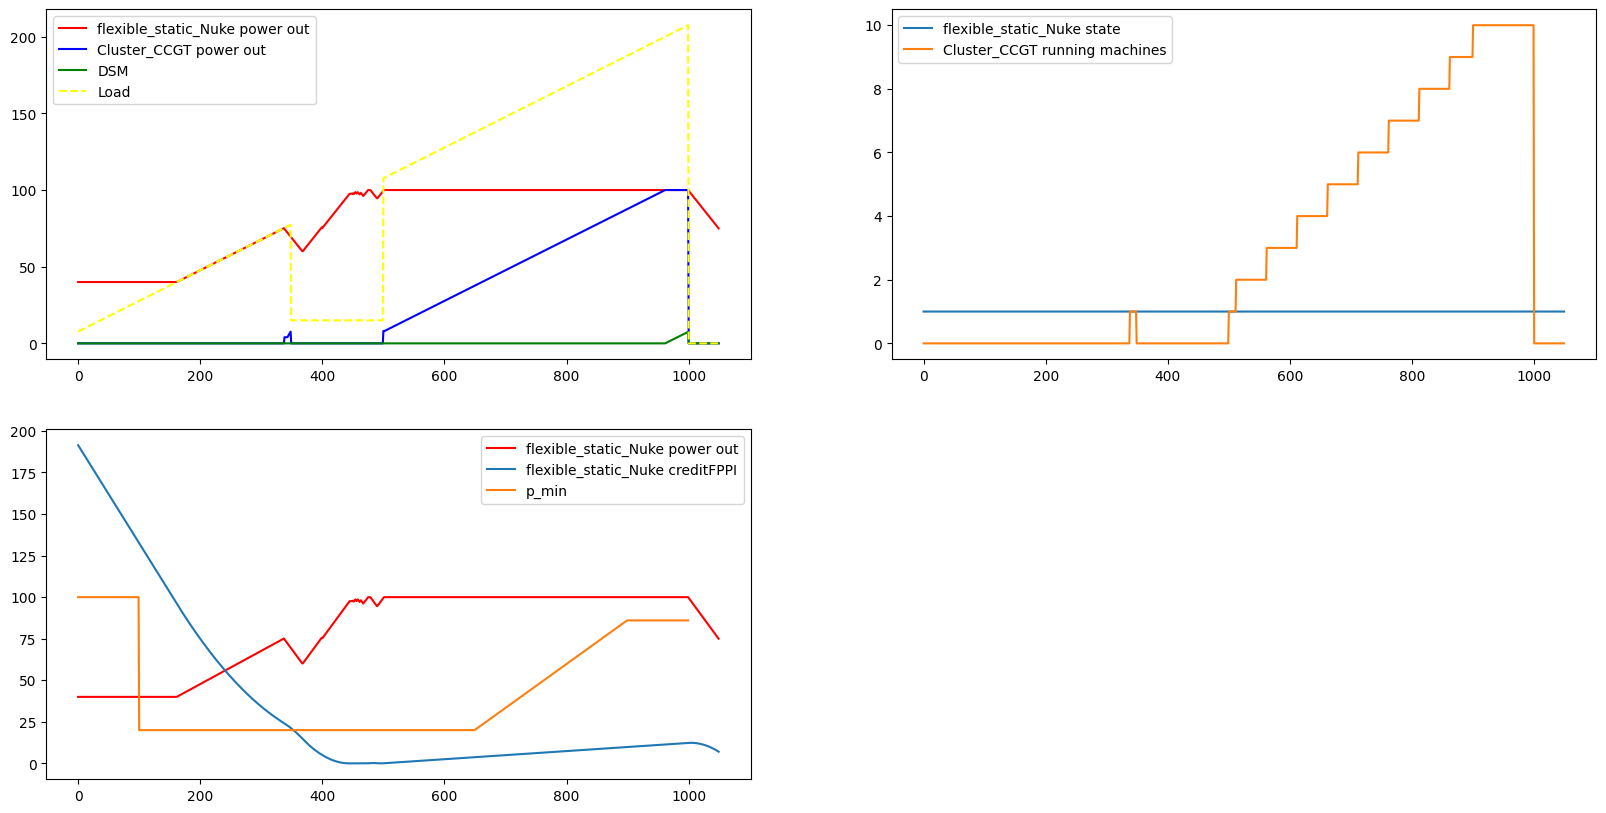

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(results["flexible_static_Nuke"]["electricity"], label = "flexible_static_Nuke power out", color="r")
#plt.plot(results["cluster_Nuke"]["power_out"], label = "Cluster_Nuke power out", color="r")
plt.plot(results["cluster_CCGT"]["power_out"], label = "Cluster_CCGT power out", color="b")
plt.plot(results["Demand-side Management"]["power_out"], label = "DSM", color="g")
plt.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="yellow")
plt.legend()
plt.subplot(222)
plt.plot(results["flexible_static_Nuke"]["boolstate"], label = "flexible_static_Nuke state")
#plt.plot(results["cluster_Nuke"]["n_machine"], label = "Cluster_Nuke running machines")
plt.plot(results["cluster_CCGT"]["n_machine"], label = "Cluster_CCGT running machines")
plt.legend()
plt.subplot(223)
plt.plot(results["flexible_static_Nuke"]["electricity"], label = "flexible_static_Nuke power out", color="r")
plt.plot(results["flexible_static_Nuke"]["creditFPPI"], label = "flexible_static_Nuke creditFPPI")
#plt.plot(ratio_p_min, label = "p_min")
plt.legend()
plt.show()

# print(results["flexible_static_Nuke"]["boolstate"][396:401])
# print(results["flexible_static_Nuke"]["electricity"][395:415]) 

# Questions :
# 

# Statut :
# Code fonctionnel pour les rampes et le creditFPPI. Début de travail sur l'évolution de p_min mais code non-fonctionnel à ce stade : passage en v2.